# Alzheimer prediction using gray matter density from T1w MRI

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

try:
  import google.colab
  IN_COLAB = True
  print('You are using Google Colab')
  !pip install googledrivedownloader
  from googledrivedownloader import download_file_from_google_drive
except:
  IN_COLAB = False


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\maeli\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
if IN_COLAB:
    print("you are using google colab")
    download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
    dest_path='./dataTP.npz')
    download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
    dest_path='./AtlasAAL2.nii')
    download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
    dest_path='./AtlasAICHA.nii')
    download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
    dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas
    y = data['y'] # classes, 0 for controls and 1 for patients
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS

In [5]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

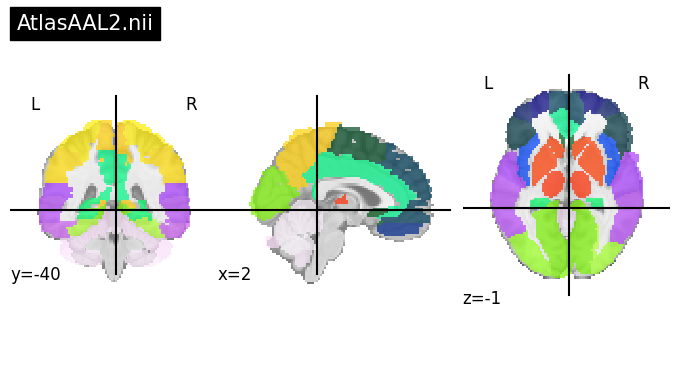

In [6]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [7]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used.

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training.

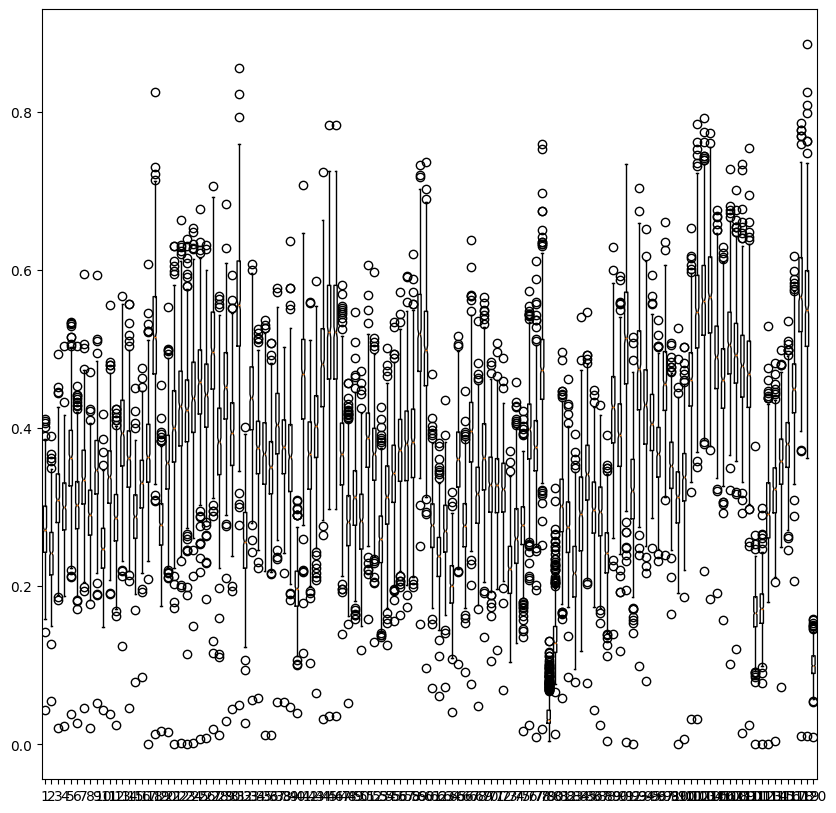

In [8]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

# Standardization/Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Then, we can fit a Decision tree, with the default setting, using the following code:

In [9]:
# Fitting Decision Trees
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7389380530973452


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ?


**ANSWER :**
Pour un `random_state`= 0, on a pour meilleure valeur : 
- min_samples_split = 2 qui maximise le training score
- min_samples_split = 14 qui maximise le test score.

Le min_samples_split qui maximise le training score ne change pas si on augmente le `random_state` et reste à 2. Cependant, celui qui maximise le test score est très fluctuant suivant la valeur du `random_state`, et diminue. 

Il pourrait etre intéressant de choisir une moyenne des 2 scores, ou de jouer un peu sur le `random_state`, ce qui pourrait rapprocher les 2 min_samples_split optimaux. Il faut aussi faire attention à ne pas avoir un trop grand training score par rapport au test score, ce qui risquerait d'overfit les données...

De même, pour min_samples_leaf, on a pour meilleure valeur :
- min_samples_leaf = 2 qui maximise le training score,
- min_samples_leaf = 8 qui maximise le test score. 

Cependant, ce paramètre est beaucoup plus stable car il ne change pas de valeurs maximales (que ce soit pour maximiser le training score ou le test score)


The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  2


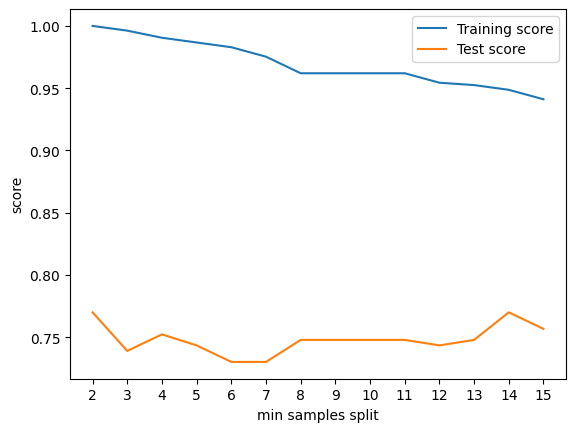

In [28]:
TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=10)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  8


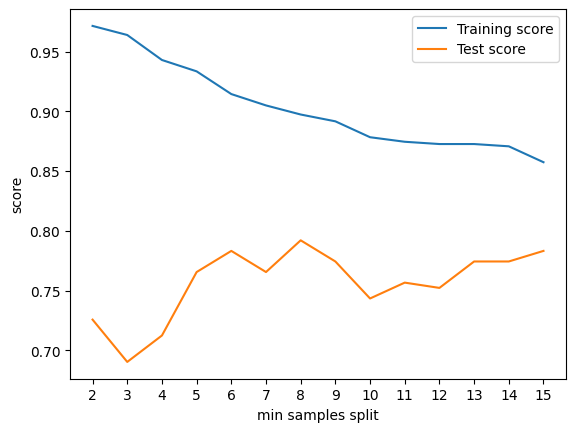

In [27]:
# min_samples_leaf
TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=20)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_leaf that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

Try to add Gaussian noise to the data (using for instance zero mean and 0.02 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise.

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

**Answer :**
Les résultats ne sont pas très stables : on observe une fluctuation autour de la moyenne, et ce n'est pas centré sur l'original ( un peu en dessous). 

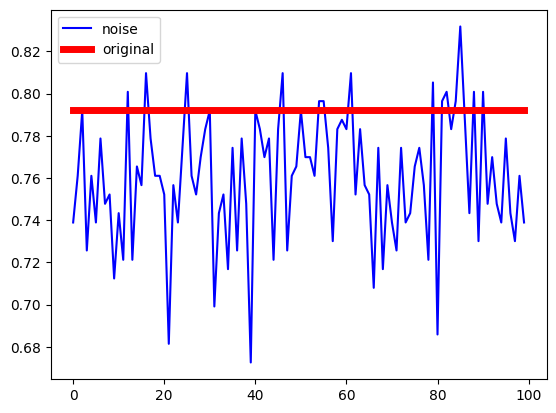

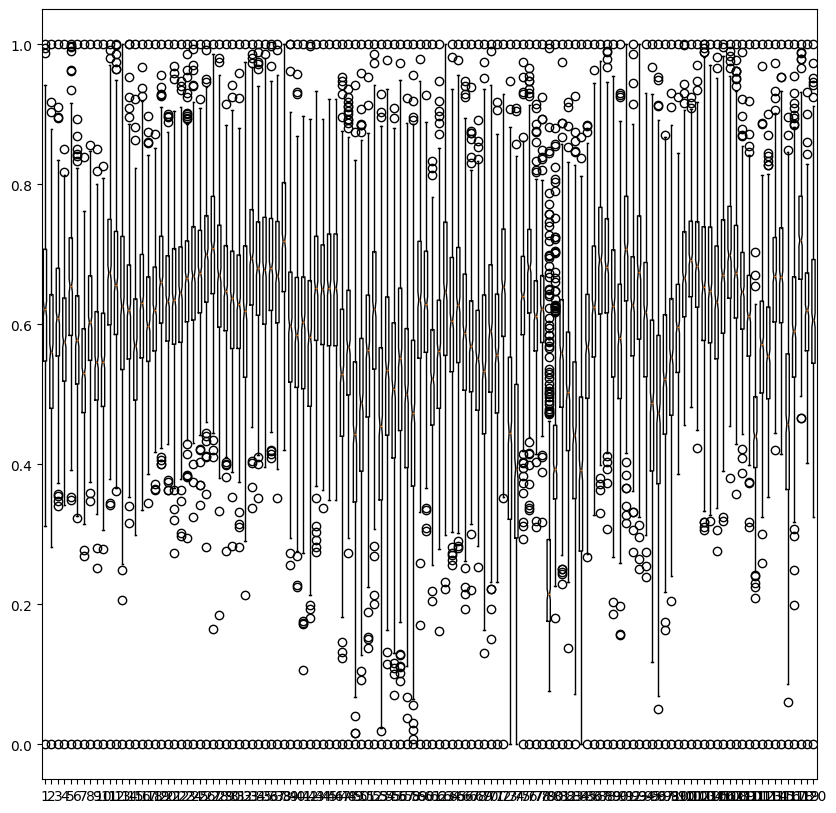

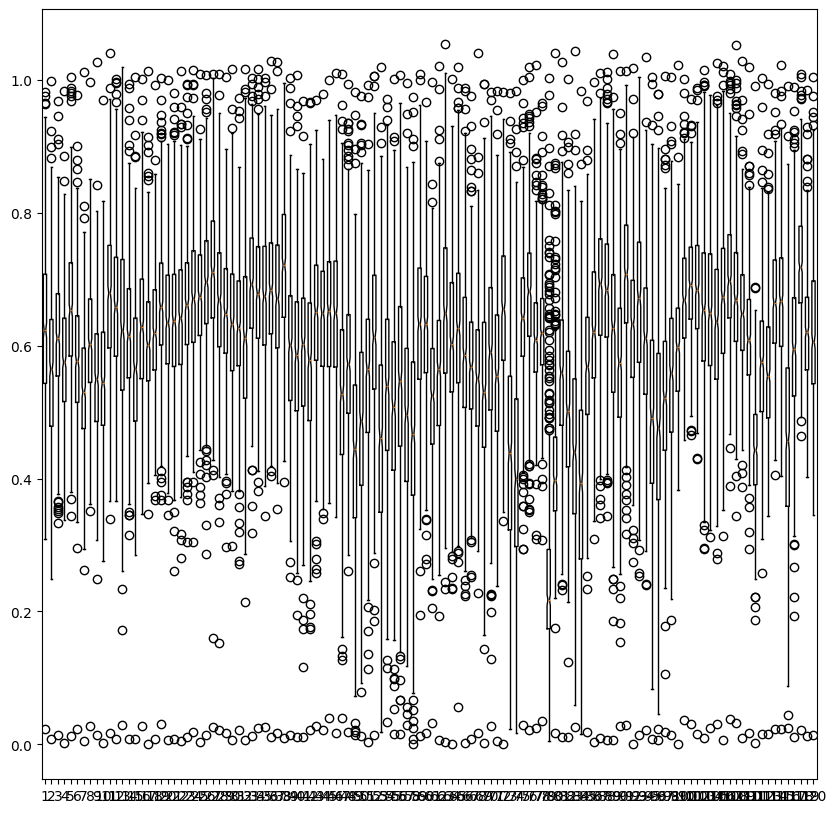

In [35]:
Tree = DecisionTreeClassifier(min_samples_split=14,min_samples_leaf=8,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)

for k in range(100):
    X_train_temp=np.copy(X_train)
    for i in range(X_train_temp.shape[0]):
        X_train_temp[i] = np.abs(np.random.normal(X_train_temp[i], 0.02))

    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)

plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')
plt.legend();

plt.figure(figsize=(10,10))
plt.boxplot(X_train,notch=True);

plt.figure(figsize=(10,10))
plt.boxplot(X_train_temp,notch=True);

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*.


First plot the tree learnt on the original data, witout adding noise.

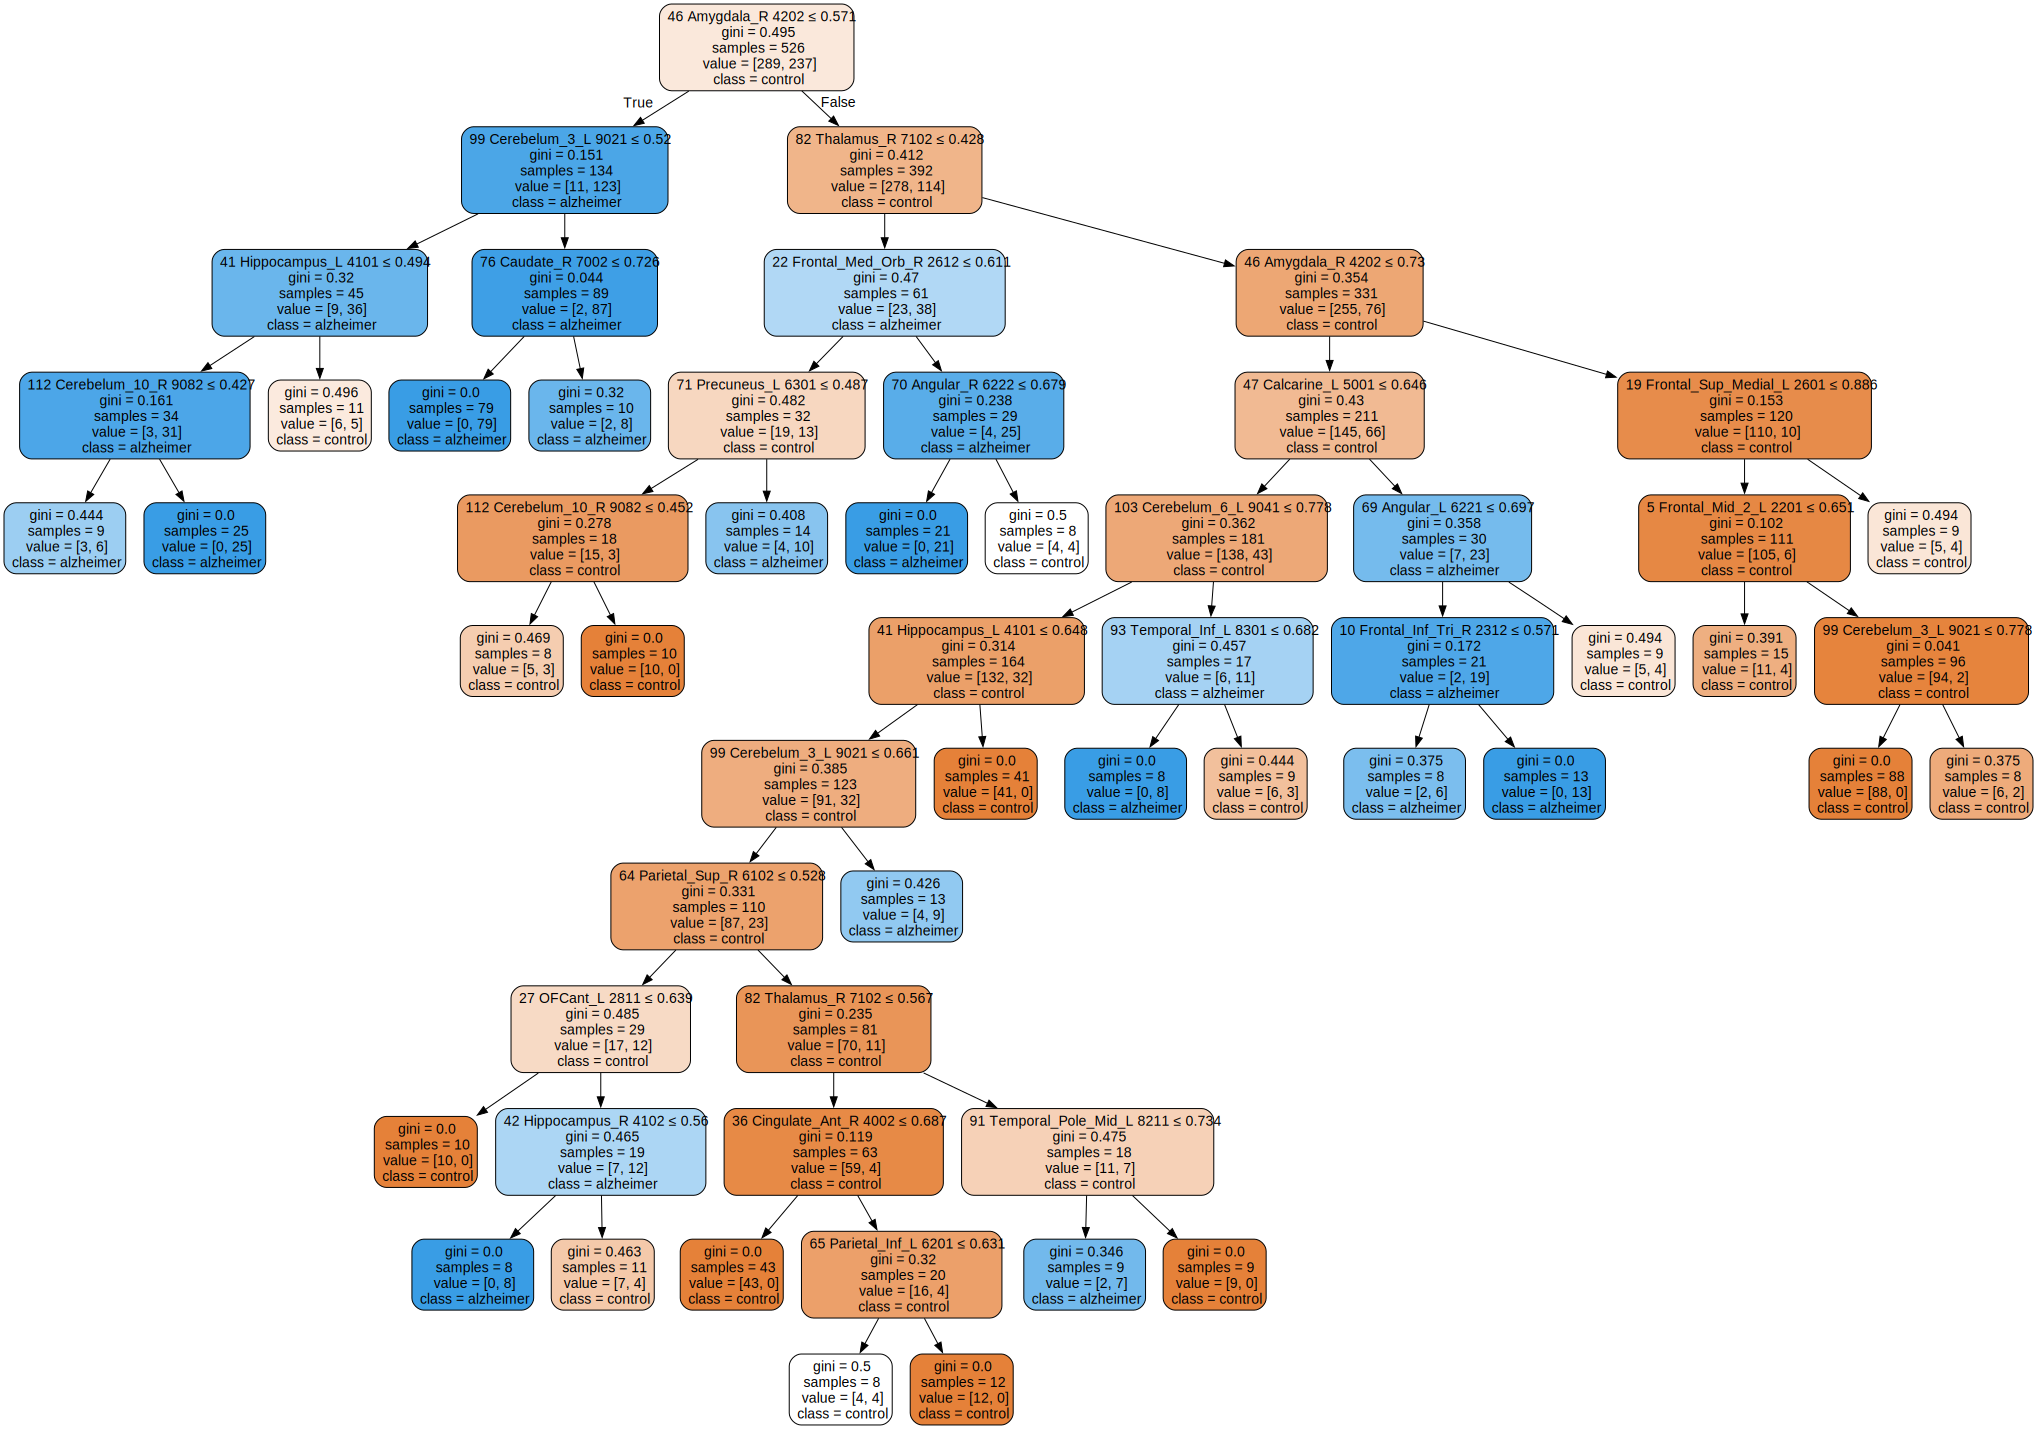

In [13]:
import graphviz

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

**answer :**
Les arbres ne sont pas les mêmes dès le premier noeud. L'arbre entraîné sur les données bruitées est moins profond que l'arbre entraîné sur les raw data, et a plus de feuilles. 

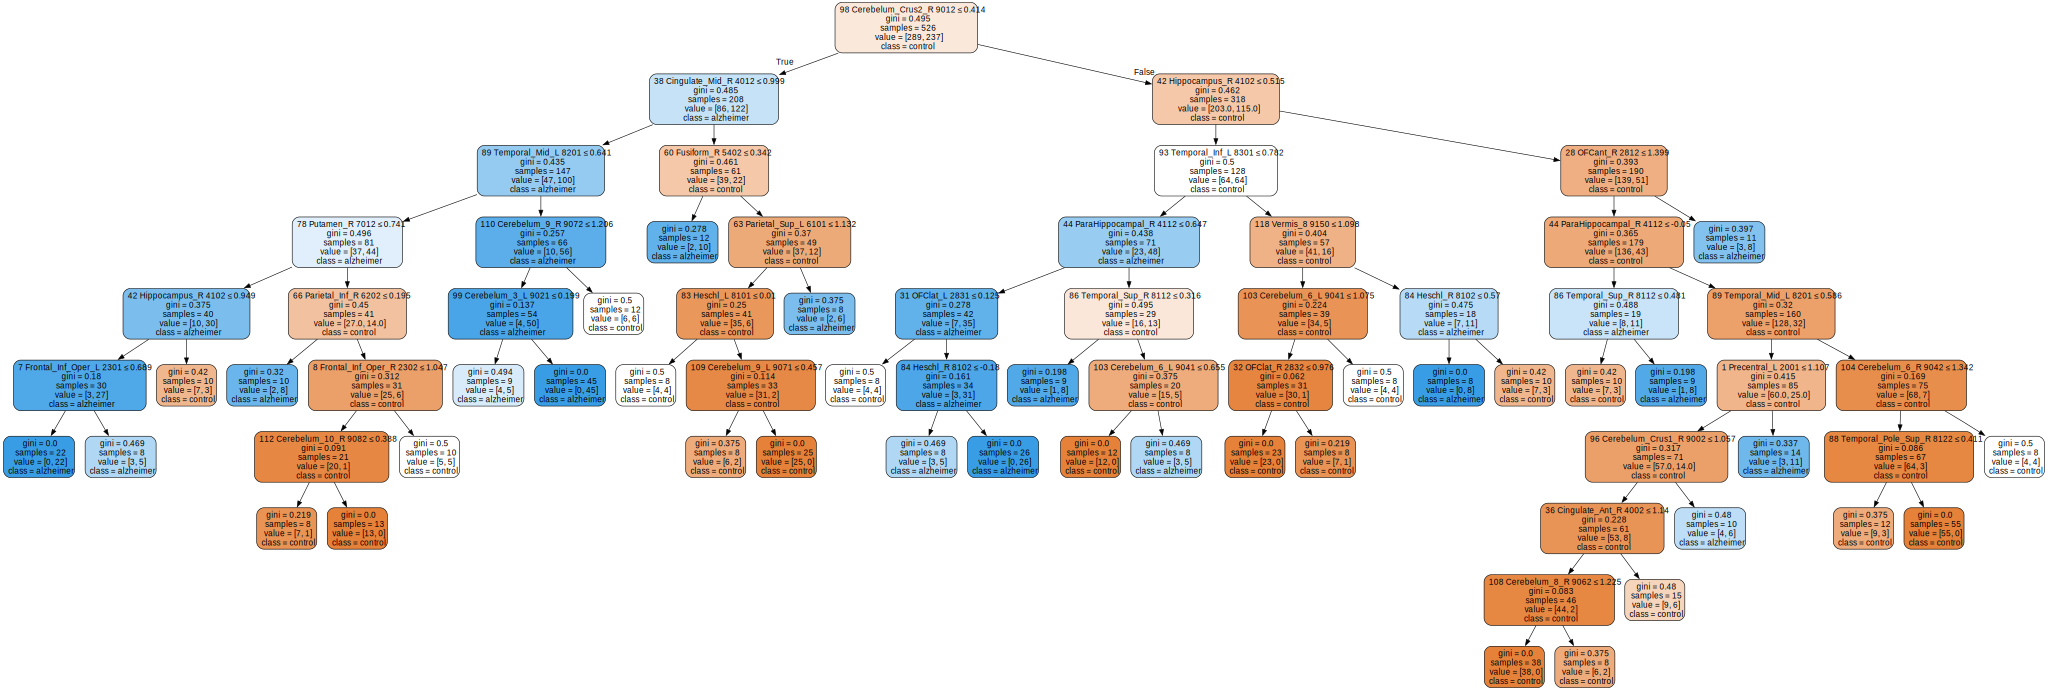

In [14]:
Tree.fit(X_train_temp,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph


Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way.

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**answer 1 :**
Les hyperparamètres optimaux ne sont pas exactement les mêmes :
- pour le min_samples_split : on trouve bien 2 comme on trouvait couramment précédemment.
- pour le min_samples_leaf : on trouve ici 10, ce qui est un peu plus élevé que ce que nous trouvions au dessus (entre 2 et 8).

**answer 2 :**
J'utiliserai aussi le *f1* score pour avoir une meilleure balance de classe si on n'a pas exactement le meme nombre d'éléments dans chaque classe. 
Sans être les mêmes, les résultats sont proches (2 et 9 alros qu'on avait 2 et 10). 

In [37]:
Tree = DecisionTreeClassifier(random_state=0)
p_grid_tree = {'min_samples_split' : np.arange(2,16),'min_samples_leaf' : np.arange(2,16)}
grid_tree = GridSearchCV(estimator=Tree,param_grid=p_grid_tree,scoring='accuracy', cv=5)
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7490386343216533
Best params: {'min_samples_leaf': np.int64(10), 'min_samples_split': np.int64(2)}
Tree test score : 0.7433628318584071


In [36]:
Tree = DecisionTreeClassifier(random_state=0)
p_grid_tree = {'min_samples_split' : np.arange(2,16),'min_samples_leaf' : np.arange(2,16)}
grid_tree = GridSearchCV(estimator=Tree,param_grid=p_grid_tree, scoring='f1', cv=5)
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7249195249195249
Best params: {'min_samples_leaf': np.int64(9), 'min_samples_split': np.int64(2)}
Tree test score : 0.7671232876712328


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library.

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Answer :**
L'ordre de l'arbre n'st pas le même et les features n'appraissent pas dans le même ordre. On remarque que la 1ere feature (à la racine) est la meme que celle à l'origine de l'arbre entraîné à partir des données originales non bruitées : *46 Amygdala_R*. On remarque que *99 Cerebelum*, *82 Thalamus_R* et *41 Hippocampus* sont aussi proches de la racine dans tous les arbres. Cela montre donc l'importance de ces features.

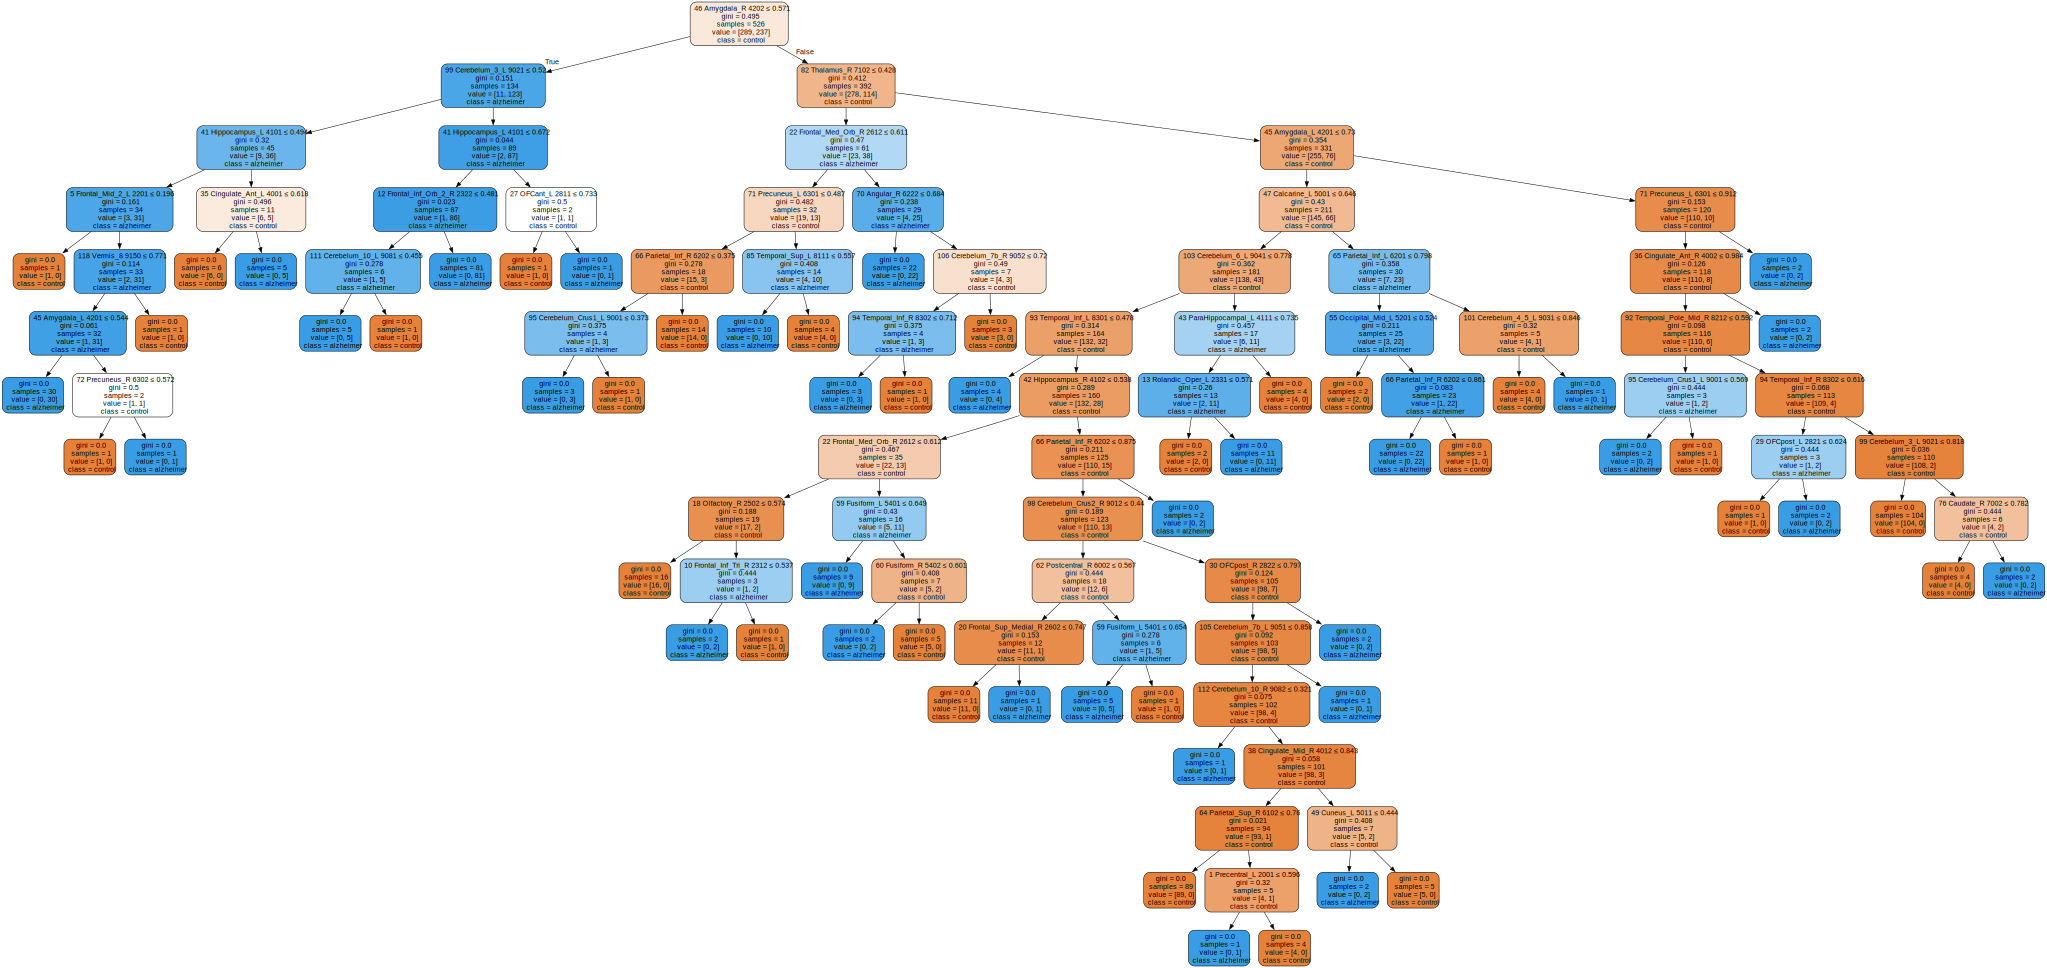

In [38]:
Tree.fit(X_train,y_train)
p_grid_tree = {'min_samples_split' : 2, 'min_samples_leaf' : 10}
grid_tree = GridSearchCV(estimator=Tree,param_grid=p_grid_tree,cv=5)



dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'.

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ?

**Answer :**
L'ajout de bruit aux données avant l'entraînement d'un modèle d'ensemble basé sur des arbres de décision améliore la robustesse et la généralisation en introduisant de la diversité parmi les arbres et en réduisant le risque de surajustement. Cela conduit à un modèle plus stable et performant sur des données non vues, bien que l'interprétabilité des arbres individuels puisse être légèrement affectée. Toutefois, l'ajout de bruit nécessite un ajustement minutieux pour trouver un équilibre entre robustesse et lisibilité du modèle. Par ailleurs, l'utilisation de données bruitées peut nécessiter un plus grand nombre de classificateurs faibles pour maintenir des performances comparables. 

Malgré cette variabilité, les scores de prédiction restent globalement similaires, ce qui confirme la robustesse de l'algorithme.

In [17]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, cv=5)
grid_bagging.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

Best Validation Score: 0.8080682839173405
Best params: {'n_estimators': 20}
Bagging test score : 0.8495575221238938


In [18]:
# Bagging on noisy data
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, cv=5)
grid_bagging.fit(X_train_temp, y_train)
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test ,y_test))

C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

Best Validation Score: 0.5969451931716083
Best params: {'n_estimators': 10}
Bagging test score : 0.6061946902654868


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [19]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}

grid_RF = GridSearchCV(estimator= RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Best Validation Score: 0.8174842767295598
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 20}
Random Forest test score : 0.8407079646017699


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging.

In [20]:
# Random Forest on noisy data
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}

grid_RF = GridSearchCV(estimator= RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train_temp, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Best Validation Score: 0.6102246181491464
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 20}
Random Forest test score : 0.6371681415929203


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.111574)
2. feature 92 representing 93 Temporal_Inf_L 8301
 (0.065617)
3. feature 40 representing 41 Hippocampus_L 4101
 (0.061331)
4. feature 93 representing 94 Temporal_Inf_R 8302
 (0.058319)
5. feature 44 representing 45 Amygdala_L 4201
 (0.051258)
6. feature 43 representing 44 ParaHippocampal_R 4112
 (0.045778)
7. feature 41 representing 42 Hippocampus_R 4102
 (0.041394)
8. feature 59 representing 60 Fusiform_R 5402
 (0.025126)
9. feature 86 representing 87 Temporal_Pole_Sup_L 8121
 (0.024041)
10. feature 42 representing 43 ParaHippocampal_L 4111
 (0.017851)


C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


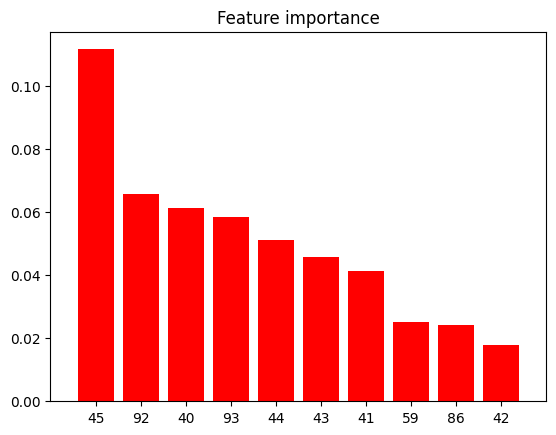

In [21]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense.

**Answer :**
D'après nos résultats, les features les plus importantes sont *46 Amygdala_R 4202* et *93 Temporal_Inf_L 8301*.

Pour ce qui est de la : *93 Temporal_Inf_L 8301*
*They showed that the connectivity strength between medial structures, temporal, and subcortical regions was most effective in classifying Mild Cognitive Impairment (MCI). In contrast, the connectivity strength between frontal areas and the rest of the brain was the best predictor for Alzheimer's Disease (AD).* Donc le résultat semble cohérent.

Pour l'*46 Amygdala_R 4202*, on sait que l'Amygdala appartient au système limbic. 
*For example, a recent study has shown that hippocampal-sparing and limbic-predominant Alzheimer's Disease (AD) subtypes might account for about 25% of AD cases.* Le résultat est donc cohérent.

We can also inspect the data using only pairs of the most important features

C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

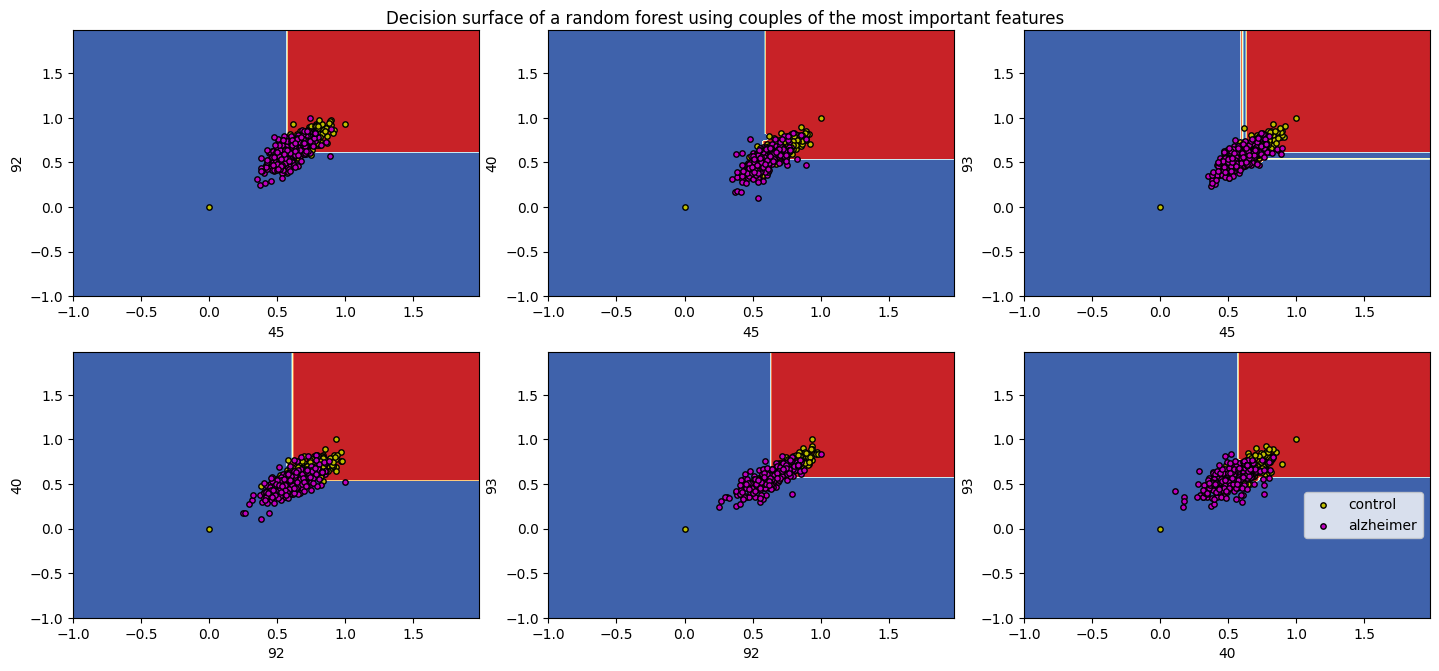

In [22]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i], edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

**Answer :**
Le meilleur coupe de features semble etre celui de (45, 92) car leurs scores étaient meilleurs, et la classifiaction (visuelle) semble cohérente.

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

**observation**
La feature parietal-occipitale semble etre prédomminente. Ce n'est pas aberrant puisqu'elle est mentionnée à plusieurs reprises dans l'article, sans que des chiffres ne soient donnés : *Later, atrophy in temporal, parietal and frontal neocortices is associated with neuronal loss, as well as language, praxic, visuospatial and behavioral impairments.*

HAMMERS a obtenu des résultats similaires à AAL2, comme mentionné dans l'article de référence. En revanche, AICHA a donné des résultats plus variés.

In [45]:
from sklearn.preprocessing import StandardScaler
# Choose AICHA (here AAL2)
X=T1AICHA # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAICHA # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAICHA.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape 
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))


# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#on appliqeu RandomForest sur les données bruitées
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='f1', cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test, y_test.ravel()))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192
Best Validation Score: 0.7263557716898665
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 20}
Random Forest test score : 0.6451612903225806


Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.069959)
2. feature 187 representing 188	N_Thalamus-5	189
 (0.033387)
3. feature 173 representing 174	N_Caudate-1	175
 (0.024185)
4. feature 188 representing 189	N_Thalamus-6	190
 (0.022884)
5. feature 145 representing 146	S_Parietooccipital-5	147
 (0.019006)
6. feature 172 representing 173	N_Amygdala-1	174
 (0.015605)
7. feature 184 representing 185	N_Thalamus-2	186
 (0.015285)
8. feature 189 representing 190	N_Thalamus-7	191
 (0.014706)
9. feature 170 representing 171	G_Fusiform-6	172
 (0.013741)
10. feature 186 representing 187	N_Thalamus-4	188
 (0.013678)


C:\Users\maeli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


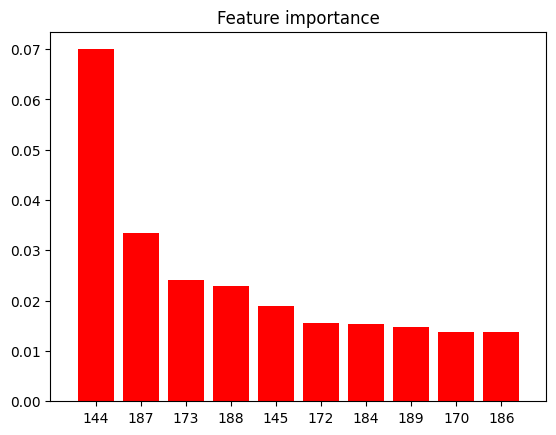

In [46]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

